
# Домашнее задание №2
## **Применение нейронных сетей для классификации**
#### Выполнил: Артамонов Д., МАГ ИАД 2020
https://www.kaggle.com/gauravdesurkar/lt-vehicle-loan-default-prediction

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
import torch
import os
import numpy as np

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Вспомним как выглядят наши данные

In [2]:
data_path = 'VehicleLoanDefaultPrediction'
data = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [3]:
data.head(5)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


Несбалансированность классов:

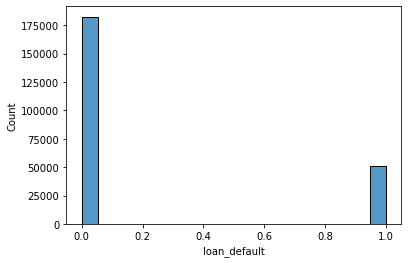

In [4]:
sns.histplot(data=data, x="loan_default")
plt.show()

Всю логику по препроцессингу данных реализуем внутри Pytroch Dataset. При инициализации он будет принимать путь к csv-табличке, считывать  обрабатывать данные, а также балансировать классы. Так как данных достаточно, в качестве балансировки мы можем просто удалить часть данных "перевешивающего" класса. Датасет сам разделит данные на train/test и будет выдавать нужные в зависимости от режима(train/test)

In [5]:
import loan_dataset

In [278]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, mode='train', test_size=0.2)

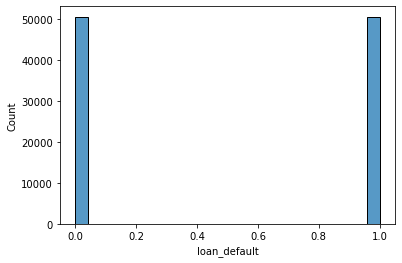

In [279]:
sns.histplot(dataset.data, x="loan_default")
plt.show()

Размеры тренировочной и тестовой выборок

In [286]:
dataset.X_train.shape

(80977, 35)

In [156]:
dataset.X_test.shape

(20245, 35)

Заиспользуем видеокарту

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Пробуем различные архитектуры

In [16]:
from torch.nn import Sequential
import torch.nn as nn
import torch.optim as optim

Определим функцию для рассчёта accuracy. Так как на выходе из модели сигмоида не применяется, мы должны это учитывать при рассчёте

In [15]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    
    return acc

In [ ]:
input_size = dataset.get_shape()[1]

In [292]:
hidden_sizes = 64
model = Sequential(nn.Linear(input_size, hidden_sizes),
                   nn.ReLU(),
                   nn.Linear(hidden_sizes, 1)
                  )
model.to(device)

Sequential(
  (0): Linear(in_features=35, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)

In [293]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

Инициализируем даталоадер, с помощью которого мы будем итерироваться по выборке

In [294]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [295]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [296]:
model.train()
for epoch in range(EPOCHS): 

    epoch_loss = 0.0
    epoch_acc = 0.0
    i_last = 0
    for i, data in enumerate(dataloader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()

        # print statistics        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        i_last = i
    

    print(f'[{epoch + 1}] loss: {epoch_loss / i_last}, accuracy: {epoch_acc/i_last}')


print('Finished Training')

[1] loss: 472.65569641995336, accuracy: 0.5170926819441347
[2] loss: 271.3453169366588, accuracy: 0.5186490060548066
[3] loss: 248.9705695621581, accuracy: 0.5190580679022747
[4] loss: 162.40127626765857, accuracy: 0.5178722971512866
[5] loss: 156.5089729363268, accuracy: 0.5246040165188756
[6] loss: 48.53182550982053, accuracy: 0.511724017672388
[7] loss: 15.062640149885487, accuracy: 0.514551121832825
[8] loss: 10.845728363986073, accuracy: 0.500890054639149
[9] loss: 1.423997522389936, accuracy: 0.5001612996984376
[10] loss: 1.9948290467969043, accuracy: 0.4995807661015997
[11] loss: 1.34833719652632, accuracy: 0.5004824459434969
[12] loss: 1.1784348065438477, accuracy: 0.500494797722153
[13] loss: 0.99497957983507, accuracy: 0.5009518135324297
[14] loss: 0.6932827331096287, accuracy: 0.5010135724257103
[15] loss: 0.6932827265130672, accuracy: 0.5010135724257103
[16] loss: 0.6932827219897109, accuracy: 0.5010135724257103
[17] loss: 0.6932827208353125, accuracy: 0.5010135724257103
[1

Loss падает, а accuracy не меняется

Посмотрим на результаты на тестовой выборке:

In [297]:
dataset.set_mode('test')
test_dataloader = DataLoader(dataset=dataset, batch_size=1)

In [306]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_test in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())


In [319]:
len(y_pred_list)

20245

In [311]:
y_pred_list = [a.squeeze().item() for a in y_pred_list]

In [313]:
y_pred_list  = np.array(y_pred_list)

In [317]:
y_pred_list[y_pred_list > 0.5].sum()

20239.0

Модель практически всегда предсказывает единицу. Единица означает, что человек проспрочит выплату. Либо модель потеряла веру в людей, либо признаки в датасете не дают никаких шансов предсказывать точнее,чем 50 на 50

### Нормализация

Добавим нормализацию к числовым фичам и попробуем обучить модель ещё раз

In [13]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, normalize=True, mode='train', test_size=0.2)

In [17]:
input_size = dataset.get_shape()[1]
hidden_sizes = 64
model = Sequential(nn.Linear(input_size, hidden_sizes),
                   nn.ReLU(),
                   nn.Linear(hidden_sizes, 1)
                  )
model.to(device)

Sequential(
  (0): Linear(in_features=35, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
model.train()
for epoch in range(EPOCHS): 

    epoch_loss = 0.0
    epoch_acc = 0.0
    i_last = 0
    for i, data in enumerate(dataloader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()

        # print statistics        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        i_last = i
    

    print(f'[{epoch + 1}] loss: {epoch_loss / i_last}, accuracy: {epoch_acc/i_last}')


print('Finished Training')

[1] loss: 8.38466224617402, accuracy: 0.512797169263655
[2] loss: 3.5232519856908104, accuracy: 0.5193930190660265
[3] loss: 3.0358932612206155, accuracy: 0.5234909032880082
[4] loss: 2.762283181095783, accuracy: 0.5238491048690359
[5] loss: 2.516505836498125, accuracy: 0.5262112008842084
[6] loss: 2.0810781646151786, accuracy: 0.5257033248192708
[7] loss: 2.0691115538357745, accuracy: 0.5260862299576107
[8] loss: 1.8149943249734495, accuracy: 0.5279745989401821
[9] loss: 1.6809602002027948, accuracy: 0.5289147872698637
[10] loss: 1.4268374684299876, accuracy: 0.5291741746216423
[11] loss: 1.3500374873871859, accuracy: 0.5295432748295101
[12] loss: 1.2694898613945769, accuracy: 0.5253560218650833
[13] loss: 1.1842506761136262, accuracy: 0.5295461811213625
[14] loss: 1.1622218790143846, accuracy: 0.5285318821315238
[15] loss: 1.0926299559504618, accuracy: 0.5313204778041765
[16] loss: 1.0547530930739617, accuracy: 0.5311381074279664
[17] loss: 0.9758867811779731, accuracy: 0.53127397699

Нормализация даже помогла! Жаль не сильно

In [30]:
dataset.set_mode('test')
test_dataloader = DataLoader(dataset=dataset, batch_size=1)
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_test in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_test.cpu().numpy())


In [31]:
len(y_pred_list)

20245

In [33]:
y_pred_list = np.array([a.squeeze().item() for a in y_pred_list])
y_true_list = np.array([a.squeeze().item() for a in y_true_list])

In [25]:
y_pred_list[y_pred_list > 0.5].sum()

13204.0

Уже не одни единички!

In [27]:
from sklearn.metrics import f1_score, accuracy_score

In [36]:
f1_score(y_true_list,y_pred_list)

0.6238211069858746

In [37]:
accuracy_score(y_true_list,y_pred_list)

0.56458384786367

Не так уж и плохо!😁

### Добавим ещё один слой

In [38]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, normalize=True, mode='train', test_size=0.2)

In [40]:
input_size = dataset.get_shape()[1]
model = Sequential(nn.Linear(input_size, 64),
                   nn.ReLU(),
                   nn.Linear(64, 64),
                   nn.ReLU(),
                   nn.Linear(hidden_sizes, 1)
                  )
model.to(device)

Sequential(
  (0): Linear(in_features=35, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [41]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [42]:
model.train()
for epoch in range(EPOCHS): 

    epoch_loss = 0.0
    epoch_acc = 0.0
    i_last = 0
    for i, data in enumerate(dataloader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()

        # print statistics        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        i_last = i
    
    print(f'[{epoch + 1}] loss: {epoch_loss / i_last}, accuracy: {epoch_acc/i_last}')
print('Finished Training')

[1] loss: 5.490227234587368, accuracy: 0.5071138979418004
[2] loss: 1.5172485000531193, accuracy: 0.5163653801552391
[3] loss: 1.0761470808695428, accuracy: 0.5237037898170147
[4] loss: 0.8558219431417262, accuracy: 0.5304217042659111
[5] loss: 0.7773317164583169, accuracy: 0.5288915368525878
[6] loss: 0.724715863904463, accuracy: 0.5276287491378105
[7] loss: 0.7009315872145264, accuracy: 0.5364864275860692
[8] loss: 0.6902317666253553, accuracy: 0.5402522669243718
[9] loss: 0.6893473392654313, accuracy: 0.5380921588113656
[10] loss: 0.6923985961633238, accuracy: 0.5155639676826274
[11] loss: 0.6929890446747716, accuracy: 0.5032368925838131
[12] loss: 0.6934459538092255, accuracy: 0.5006306672873704
[13] loss: 0.6934438060159268, accuracy: 0.5008777028604929
[14] loss: 0.693772032279742, accuracy: 0.5010629795403349
[15] loss: 0.6934453373369963, accuracy: 0.5009024064178053
[16] loss: 0.6934453970123186, accuracy: 0.5009024064178053
[17] loss: 0.6934453973892649, accuracy: 0.500902406

In [43]:
dataset.set_mode('test')
test_dataloader = DataLoader(dataset=dataset, batch_size=1)
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_test in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_test.cpu().numpy())


In [45]:
y_pred_list = np.array([a.squeeze().item() for a in y_pred_list])
y_true_list = np.array([a.squeeze().item() for a in y_true_list])

In [46]:
y_pred_list[y_pred_list > 0.5].sum()

20245.0

Как-то всё опять сломалось 😕 

In [47]:
f1_score(y_true_list,y_pred_list)

0.6713263765833168

In [48]:
accuracy_score(y_true_list,y_pred_list)

0.5052605581625093

### Попробуем добавить дропаут

In [49]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, normalize=True, mode='train', test_size=0.2)

In [52]:
input_size = dataset.get_shape()[1]
model = Sequential(nn.Linear(input_size, 64),
                   nn.ReLU(),
                   nn.Dropout(0.5),
                   nn.Linear(64, 64),
                   nn.Dropout(0.5),
                   nn.ReLU(),
                   nn.Linear(hidden_sizes, 1)
                  )
model.to(device)

Sequential(
  (0): Linear(in_features=35, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [53]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [54]:
model.train()
for epoch in range(EPOCHS): 

    epoch_loss = 0.0
    epoch_acc = 0.0
    i_last = 0
    for i, data in enumerate(dataloader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()

        # print statistics        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        i_last = i
    
    print(f'[{epoch + 1}] loss: {epoch_loss / i_last}, accuracy: {epoch_acc/i_last}')
print('Finished Training')

[1] loss: 4.6623958381621735, accuracy: 0.5003204196809309
[2] loss: 0.7020003935093936, accuracy: 0.5019908160913603
[3] loss: 0.6954655106124199, accuracy: 0.5012976633348013
[4] loss: 0.694736669704377, accuracy: 0.5008777028604929
[5] loss: 0.6943974586107985, accuracy: 0.5007294815166194
[6] loss: 0.6947189323044577, accuracy: 0.5002107068130621
[7] loss: 0.6946779542054112, accuracy: 0.5009024064178053
[8] loss: 0.6944712582313025, accuracy: 0.5001242443624693
[9] loss: 0.6938077283235407, accuracy: 0.5007418332952756
[10] loss: 0.693476587416155, accuracy: 0.5010012206470542
[11] loss: 0.6942914700555236, accuracy: 0.5009024064178053
[12] loss: 0.6945153543600452, accuracy: 0.5010012206470542
[13] loss: 0.6937477161055026, accuracy: 0.500890054639149
[14] loss: 0.6935446347408144, accuracy: 0.5007665368525879
[15] loss: 0.6934466507123864, accuracy: 0.5008653510818368
[16] loss: 0.6934421482529094, accuracy: 0.5009147581964614
[17] loss: 0.6934478300597828, accuracy: 0.500877702

In [55]:
dataset.set_mode('test')
test_dataloader = DataLoader(dataset=dataset, batch_size=1)
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_test in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_test.cpu().numpy())


In [56]:
y_pred_list = np.array([a.squeeze().item() for a in y_pred_list])
y_true_list = np.array([a.squeeze().item() for a in y_true_list])

In [59]:
y_pred_list[y_pred_list > 0.5].sum()

20245.0

Ровно то же самое

In [60]:
f1_score(y_true_list,y_pred_list)

0.6713263765833168

In [61]:
accuracy_score(y_true_list,y_pred_list)

0.5052605581625093

### Зависимость от числа нейронов

Вернёмся к первой молели и посмотрим на зависимость точности от числа нейронов

In [86]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, normalize=True, mode='train', test_size=0.2)

In [87]:
hidden_sizes = [30, 48, 64, 82, 128]
input_size = dataset.get_shape()[1]

In [88]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [90]:
result_dict = dict()

In [91]:
for s in hidden_sizes:
    model = Sequential(nn.Linear(input_size, s),
                       nn.ReLU(),
                       nn.Linear(s, 1)
                      )
    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.train()
    dataset.set_mode('train')
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    print(f'[Hidden size is {s}] Start Training. ')
    for epoch in range(EPOCHS): 
        if epoch % 10 == 9:
            print('>'*5, f'[Hidden size is {s}] Epoch {epoch}')
        for i, data in enumerate(dataloader):
            X_batch, y_batch = data
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            acc = binary_acc(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
    print(f'[Hidden size is {s}]Finished Training. ')
            
    result_dict[s] = model

[Hidden size is 30] Start Training. 
>>>>> [Hidden size is 30] Epoch 9
>>>>> [Hidden size is 30] Epoch 19
[Hidden size is 30]Finished Training. 
[Hidden size is 48] Start Training. 
>>>>> [Hidden size is 48] Epoch 9
>>>>> [Hidden size is 48] Epoch 19
[Hidden size is 48]Finished Training. 
[Hidden size is 64] Start Training. 
>>>>> [Hidden size is 64] Epoch 9
>>>>> [Hidden size is 64] Epoch 19
[Hidden size is 64]Finished Training. 
[Hidden size is 82] Start Training. 
>>>>> [Hidden size is 82] Epoch 9
>>>>> [Hidden size is 82] Epoch 19
[Hidden size is 82]Finished Training. 
[Hidden size is 128] Start Training. 
>>>>> [Hidden size is 128] Epoch 9
>>>>> [Hidden size is 128] Epoch 19
[Hidden size is 128]Finished Training. 


In [85]:
y_pred_tag.cpu().numpy()

array([[1.]], dtype=float32)

In [94]:
dataset.set_mode('test')
test_dataloader = DataLoader(dataset=dataset, batch_size=1)

In [111]:
f1_scores_dict= dict()
s_scores_dict= dict()
accuracy_scores_dict= dict()

In [112]:
for s, model in result_dict.items():

    
    y_pred_list = []
    y_true_list = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_test in test_dataloader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_test.cpu().numpy())

    y_pred_list = np.array([a.squeeze().item() for a in y_pred_list])
    y_true_list = np.array([a.squeeze().item() for a in y_true_list])

    f1_scores_dict[s] =  f1_score(y_true_list,y_pred_list)
    s_scores_dict[s] = y_pred_list[y_pred_list > 0.5].sum()
    accuracy_scores_dict[s] = accuracy_score(y_true_list,y_pred_list)

In [97]:
scores_dict

{30: (0.5604840701407755, 0.4217572134130491, 5159.0),
 48: (0.5183996048407014, 0.1406663141195135, 1117.0),
 64: (0.4959743146455915, 0.007199844327690212, 49.0),
 82: (0.57732773524327, 0.6416216442601667, 13648.0),
 128: (0.532279575203754, 0.6751963777312798, 18924.0)}

In [116]:
df_f1 = pd.DataFrame.from_dict(f1_scores_dict, orient='index', columns=['f1'])
df_ones = pd.DataFrame.from_dict(s_scores_dict, orient='index', columns=['ones'])
df_acc = pd.DataFrame.from_dict(accuracy_scores_dict, orient='index', columns=['accuracy'])

In [117]:
import seaborn as sns

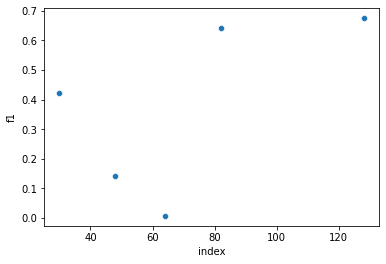

In [124]:
sns.scatterplot(x='index', y='f1', data=df_f1.reset_index())
plt.show()

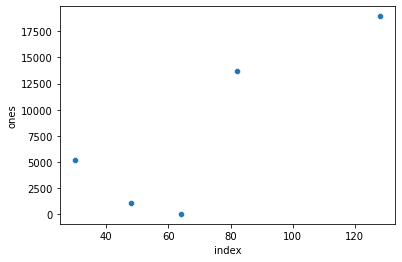

In [126]:
sns.scatterplot(x='index', y='ones', data=df_ones.reset_index())
plt.show()

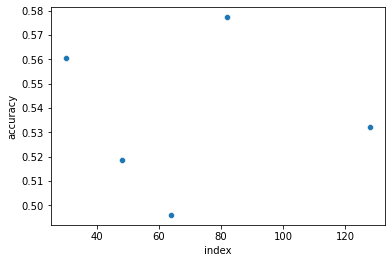

In [127]:
sns.scatterplot(x='index', y='accuracy', data=df_acc.reset_index())
plt.show()

Судя по графику, лучшее качество даёт число слоёв равное примерно 80